## Backtesting Predictions

Now that we have predictive Time-Series models, we want to backtest them against the real data. 

We cannot use a standard metric like **Sum of Squared Errors** here, because it and others like it (MAPE, RMSE, etc.) use some form of $\sum(\hat{y_{i}}-y_{i})$ which would require predictions to be accurate on a *month-by-month* basis. But earthquakes are believed to be unpredictable (see [United States Geological Survey for more](https://www.usgs.gov/faqs/can-you-predict-earthquakes)). Therefore, we want to see if our models predicted the same *number of events* over a ten-year period as the real data.

There are two types of predictions under consideration:
* Backtesting predictions against actual data
    * 2013 - 2023
* Future predictions that haven't occurred yet
    * 2023 - 2033
 
Every dataset below takes the distance-weighted energy observations from **one** lattice point, and then tries to predict monthly energy observations.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [15]:
main_df = pd.read_csv("../Data/LA_energy_1970_2023.csv")
transposed_df = main_df.drop(columns=['Latitude','Longitude']).T
transposed_df.index = pd.to_datetime(transposed_df.index, format='%Y_%m')
transposed_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,431,432,433,434,435,436,437,438,439,440
1970-01-01,321067.119801,321135.048331,321124.857167,321042.681773,320896.868751,320696.998421,320453.023487,320174.622771,319870.785259,319549.580501,...,330375.343979,331692.410816,333540.318673,335854.239982,338056.517228,338781.130565,337206.412599,334433.569361,331723.455688,329467.781893
1970-02-01,217466.025395,217858.321949,218220.005878,218560.875641,218891.321623,219219.660568,219551.121548,219889.987552,220246.145972,220647.076863,...,212851.584622,212614.553994,212357.237275,212083.543453,211797.622578,211503.571619,211205.199775,210905.873823,210608.441399,210315.216979
1970-03-01,216460.713365,217512.038970,218890.530045,220840.334270,223822.556741,228579.253880,234618.200632,235199.597137,229620.977354,224987.729336,...,217423.033571,218176.468137,219029.472636,219920.430917,220664.378128,220975.150370,220697.452192,219992.508723,219151.974410,218364.029661


### 2013 - 2023 datasets

These datasets cover 10 arbitrary lattice points for which we have monthly energy predictions. The models are:
* MLR - multiple linear regression
* LASSO - lasso regression
* XGBoost - extreme gradient boosting
* LSTM - long short term memory recurrent neural net

We also have the "actual" data to gauge predictive capabilities

In [16]:
#read in the backtested predictions
df0 = pd.read_excel('../Data/final_time_series_project0.xlsx', sheet_name='lvl_test_set_predictions')
df1 = pd.read_excel('../Data/final_time_series_project1.xlsx', sheet_name='lvl_test_set_predictions')
df2 = pd.read_excel('../Data/final_time_series_project2.xlsx', sheet_name='lvl_test_set_predictions')
df3 = pd.read_excel('../Data/final_time_series_project3.xlsx', sheet_name='lvl_test_set_predictions')
df4 = pd.read_excel('../Data/final_time_series_project4.xlsx', sheet_name='lvl_test_set_predictions')
df5 = pd.read_excel('../Data/final_time_series_project5.xlsx', sheet_name='lvl_test_set_predictions')
df6 = pd.read_excel('../Data/final_time_series_project6.xlsx', sheet_name='lvl_test_set_predictions')
df7 = pd.read_excel('../Data/final_time_series_project7.xlsx', sheet_name='lvl_test_set_predictions')
df8 = pd.read_excel('../Data/final_time_series_project8.xlsx', sheet_name='lvl_test_set_predictions')
df9 = pd.read_excel('../Data/final_time_series_project9.xlsx', sheet_name='lvl_test_set_predictions')

df0.head()

,DATE,actual,mlr,lasso,xgboost,lstm
0,2013-01-01,9.929226e+06,10943120,1.097388e+07,9369162.0,1.297938e+06
1,2013-02-01,7.521204e+06,10379920,1.042931e+07,8202414.5,1.581242e+06
2,2013-03-01,1.114660e+07,10637968,1.069990e+07,7888832.0,1.519692e+06
3,2013-04-01,1.230655e+07,9929360,1.000031e+07,8135144.5,2.068235e+06
4,2013-05-01,1.294165e+07,9941648,1.002133e+07,9618328.0,1.766591e+06


In [9]:
#read in the future predictions
pred_df0 = pd.read_excel('../Data/final_time_series_project0.xlsx', sheet_name='lvl_fcsts')
pred_df1 = pd.read_excel('../Data/final_time_series_project1.xlsx', sheet_name='lvl_fcsts')
pred_df2 = pd.read_excel('../Data/final_time_series_project2.xlsx', sheet_name='lvl_fcsts')
pred_df3 = pd.read_excel('../Data/final_time_series_project3.xlsx', sheet_name='lvl_fcsts')
pred_df4 = pd.read_excel('../Data/final_time_series_project4.xlsx', sheet_name='lvl_fcsts')
pred_df5 = pd.read_excel('../Data/final_time_series_project5.xlsx', sheet_name='lvl_fcsts')
pred_df6 = pd.read_excel('../Data/final_time_series_project6.xlsx', sheet_name='lvl_fcsts')
pred_df7 = pd.read_excel('../Data/final_time_series_project7.xlsx', sheet_name='lvl_fcsts')
pred_df8 = pd.read_excel('../Data/final_time_series_project8.xlsx', sheet_name='lvl_fcsts')
pred_df9 = pd.read_excel('../Data/final_time_series_project9.xlsx', sheet_name='lvl_fcsts')

In [10]:
#set the energy benchmarks
mag2 = 10 ** (4.4 + 1.5*2)
mag3 = 10 ** (4.4 + 1.5*3)
mag4 = 10 ** (4.4 + 1.5*4)
mag5 = 10 ** (4.4 + 1.5*5)

In [13]:
print(f"MAGNITUDE: 2")
print(f"actual:    {len(df0[df0['actual'] > mag2])} ")
print(f"mlr:       {len(df0[df0['mlr'] > mag2])} ")
print(f"lasso:     {len(df0[df0['lasso'] > mag2])}")
print(f"xgboost:   {len(df0[df0['xgboost'] > mag2])}")
print(f"lstm:      {len(df0[df0['lstm'] > mag2])}")


MAGNITUDE: 2
actual:    7 
mlr:       0 
lasso:     0
xgboost:   0
lstm:      0


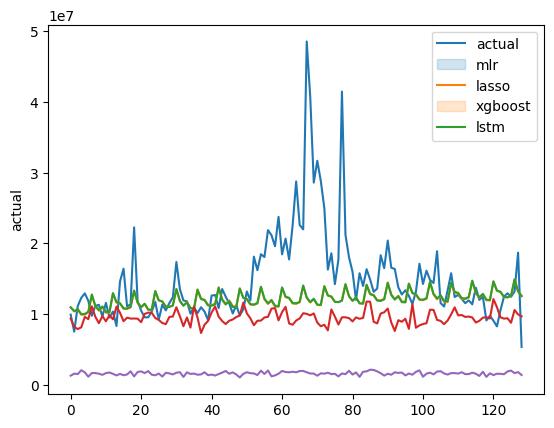

In [74]:
ax1 = sns.lineplot(df0['actual'])
ax2 = sns.lineplot(df0['mlr'])
ax3 = sns.lineplot(df0['lasso'])
ax4 = sns.lineplot(df0['xgboost'])
ax5 = sns.lineplot(df0['lstm'])

plt.legend(['actual','mlr','lasso','xgboost','lstm'])

In [75]:
def prediction_analyzer2(df, long_df, pred_df, j):
    print(f"Magnitude 2, actual:  {len(df[df['actual'] > mag2])}")
    print(f"Magnitude 2, mlr:     {len(df[df['mlr'] > mag2])}")
    print(f"Magnitude 2, lasso:   {len(df[df['lasso'] > mag2])}")
    print(f"Magnitude 2, xgboost: {len(df[df['xgboost'] > mag2])}")
    print(f"Magnitude 2, lstm:    {len(df[df['lstm'] > mag2])}")

    print("\n Predicting future Magnitude\n 1 | 2 | 3 | 4 | 5 | 6 | 7 |")
    for col in ['mlr','lasso','xgboost','lstm']:
        print(f"\n{col}")
        for i in range(1,8):
            mag = 10**(4.4+1.5*i)
            print(f"{len(pred_df[pred_df[col] > mag])}", end = ' | ')

    plt.figure(figsize=(6,3))
    sns.lineplot(df[['actual','mlr','lasso','xgboost','lstm']])
    plt.axhline(mag2, color='pink')
    plt.ylabel('Energy')
    plt.xlabel('Observation months')
    plt.title(f'Prediction models, 2013 - 2023 (grid {j})')
    plt.legend()
    plt.show()

    plt.figure(figsize=(9,3))
    sns.lineplot(long_df[i])
    plt.axhline(mag2, color='pink')
    plt.axhline(mag3, color='orange')
    plt.ylabel('Energy')
    plt.title(f'Full history, 1970 to 2023 (grid {j})')
    plt.show()

Magnitude 2, actual:  7
Magnitude 2, mlr:     0
Magnitude 2, lasso:   0
Magnitude 2, xgboost: 0
Magnitude 2, lstm:    0

 Predicting future Magnitude
 1 | 2 | 3 | 4 | 5 | 6 | 7 |

mlr
60 | 0 | 0 | 0 | 0 | 0 | 0 | 
lasso
60 | 0 | 0 | 0 | 0 | 0 | 0 | 
xgboost
60 | 2 | 0 | 0 | 0 | 0 | 0 | 
lstm
60 | 0 | 0 | 0 | 0 | 0 | 0 | 

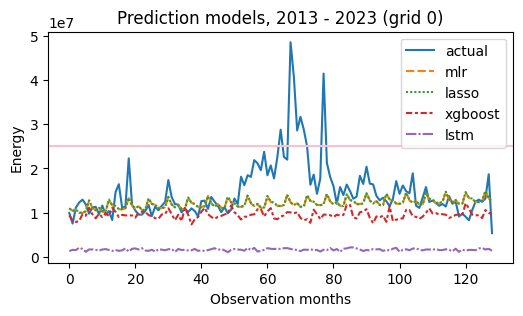

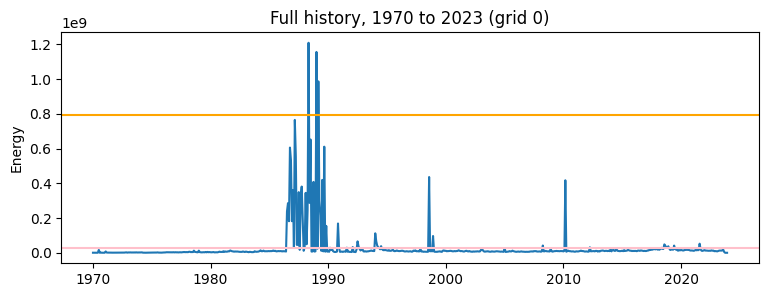

In [76]:
prediction_analyzer2(df0, transposed_df, pred_df0, 0)

Magnitude 2, actual:  7
Magnitude 2, mlr:     0
Magnitude 2, lasso:   0
Magnitude 2, xgboost: 1
Magnitude 2, lstm:    0

 Predicting future Magnitude
 1 | 2 | 3 | 4 | 5 | 6 | 7 |

mlr
60 | 0 | 0 | 0 | 0 | 0 | 0 | 
lasso
60 | 0 | 0 | 0 | 0 | 0 | 0 | 
xgboost
60 | 0 | 0 | 0 | 0 | 0 | 0 | 
lstm
60 | 0 | 0 | 0 | 0 | 0 | 0 | 

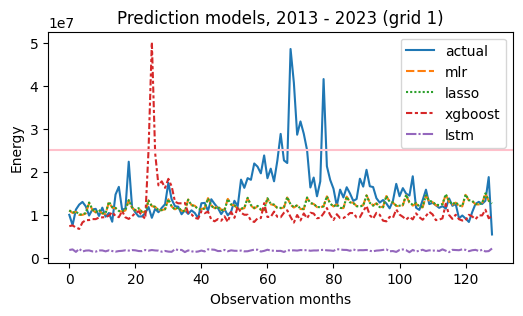

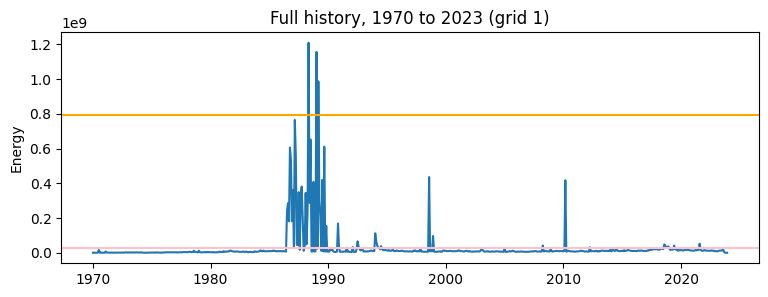

In [77]:
prediction_analyzer2(df1, transposed_df, pred_df1, 1)

Magnitude 2, actual:  7
Magnitude 2, mlr:     0
Magnitude 2, lasso:   0
Magnitude 2, xgboost: 2
Magnitude 2, lstm:    0

 Predicting future Magnitude
 1 | 2 | 3 | 4 | 5 | 6 | 7 |

mlr
60 | 0 | 0 | 0 | 0 | 0 | 0 | 
lasso
60 | 0 | 0 | 0 | 0 | 0 | 0 | 
xgboost
60 | 3 | 0 | 0 | 0 | 0 | 0 | 
lstm
60 | 0 | 0 | 0 | 0 | 0 | 0 | 

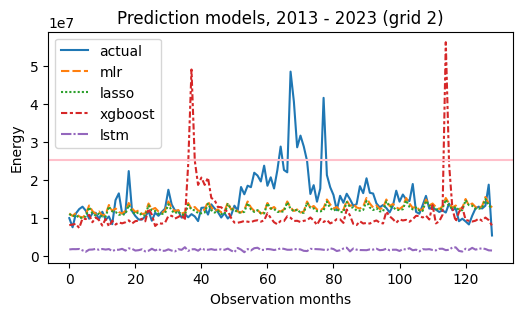

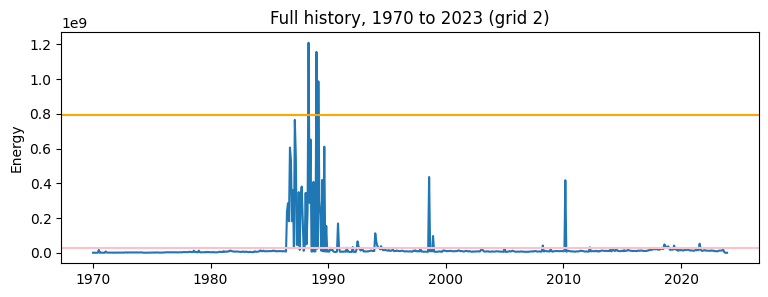

In [78]:
prediction_analyzer2(df2, transposed_df, pred_df2, 2)

Magnitude 2, actual:  8
Magnitude 2, mlr:     0
Magnitude 2, lasso:   0
Magnitude 2, xgboost: 7
Magnitude 2, lstm:    0

 Predicting future Magnitude
 1 | 2 | 3 | 4 | 5 | 6 | 7 |

mlr
60 | 0 | 0 | 0 | 0 | 0 | 0 | 
lasso
60 | 0 | 0 | 0 | 0 | 0 | 0 | 
xgboost
60 | 0 | 0 | 0 | 0 | 0 | 0 | 
lstm
60 | 0 | 0 | 0 | 0 | 0 | 0 | 

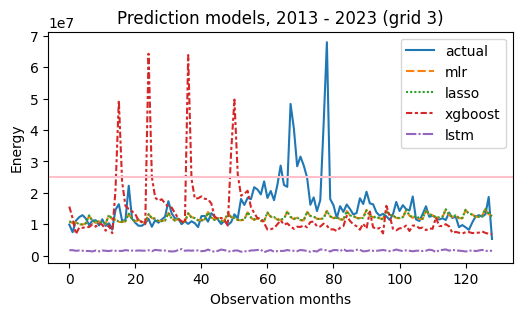

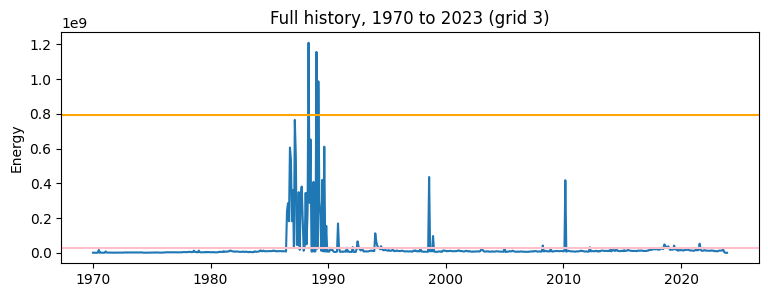

In [79]:
prediction_analyzer2(df3, transposed_df, pred_df3, 3)

Magnitude 2, actual:  7
Magnitude 2, mlr:     0
Magnitude 2, lasso:   0
Magnitude 2, xgboost: 6
Magnitude 2, lstm:    0

 Predicting future Magnitude
 1 | 2 | 3 | 4 | 5 | 6 | 7 |

mlr
60 | 0 | 0 | 0 | 0 | 0 | 0 | 
lasso
60 | 0 | 0 | 0 | 0 | 0 | 0 | 
xgboost
60 | 13 | 0 | 0 | 0 | 0 | 0 | 
lstm
60 | 0 | 0 | 0 | 0 | 0 | 0 | 

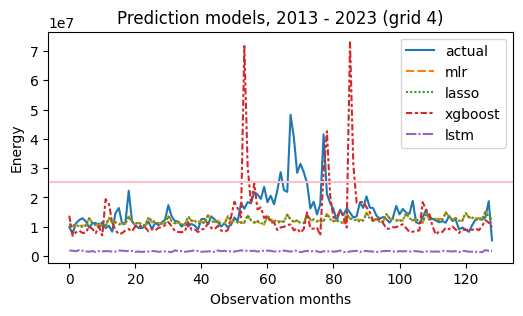

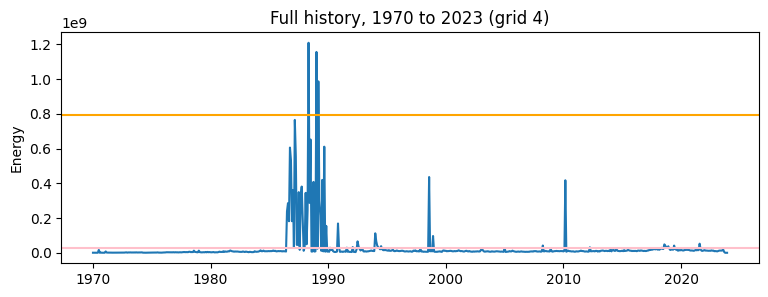

In [80]:
prediction_analyzer2(df4, transposed_df, pred_df4, 4)

Magnitude 2, actual:  7
Magnitude 2, mlr:     0
Magnitude 2, lasso:   0
Magnitude 2, xgboost: 9
Magnitude 2, lstm:    0

 Predicting future Magnitude
 1 | 2 | 3 | 4 | 5 | 6 | 7 |

mlr
60 | 0 | 0 | 0 | 0 | 0 | 0 | 
lasso
60 | 0 | 0 | 0 | 0 | 0 | 0 | 
xgboost
60 | 1 | 0 | 0 | 0 | 0 | 0 | 
lstm
60 | 0 | 0 | 0 | 0 | 0 | 0 | 

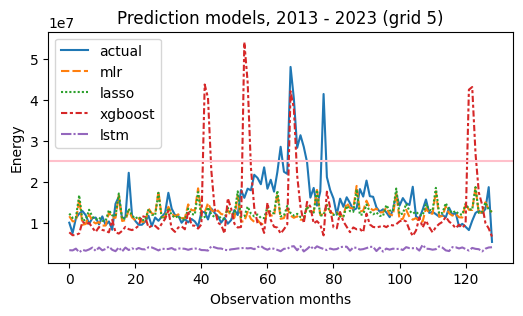

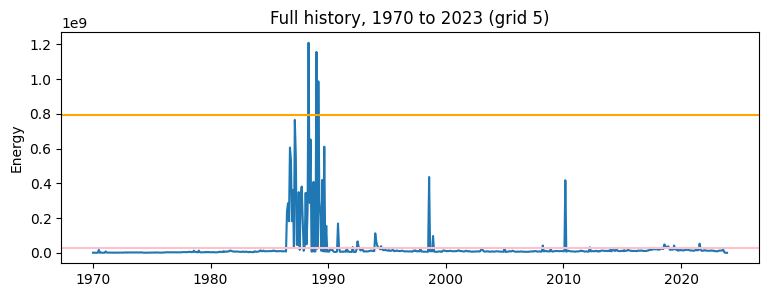

In [81]:
prediction_analyzer2(df5, transposed_df, pred_df5, 5)

Magnitude 2, actual:  7
Magnitude 2, mlr:     0
Magnitude 2, lasso:   0
Magnitude 2, xgboost: 4
Magnitude 2, lstm:    0

 Predicting future Magnitude
 1 | 2 | 3 | 4 | 5 | 6 | 7 |

mlr
60 | 0 | 0 | 0 | 0 | 0 | 0 | 
lasso
60 | 0 | 0 | 0 | 0 | 0 | 0 | 
xgboost
60 | 1 | 0 | 0 | 0 | 0 | 0 | 
lstm
60 | 0 | 0 | 0 | 0 | 0 | 0 | 

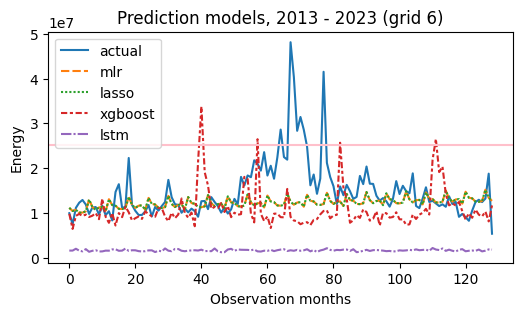

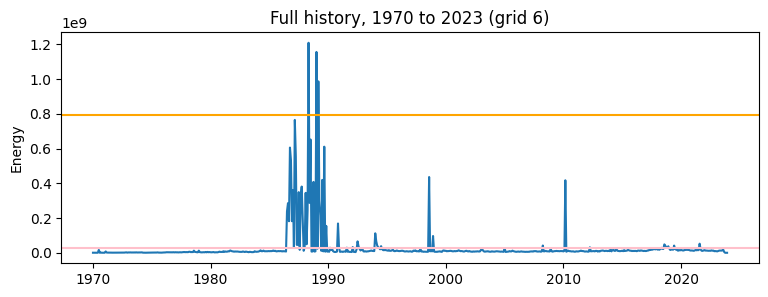

In [82]:
prediction_analyzer2(df6, transposed_df, pred_df6, 6)

Magnitude 2, actual:  8
Magnitude 2, mlr:     59
Magnitude 2, lasso:   53
Magnitude 2, xgboost: 33
Magnitude 2, lstm:    0

 Predicting future Magnitude
 1 | 2 | 3 | 4 | 5 | 6 | 7 |

mlr
42 | 4 | 0 | 0 | 0 | 0 | 0 | 
lasso
49 | 9 | 0 | 0 | 0 | 0 | 0 | 
xgboost
60 | 7 | 0 | 0 | 0 | 0 | 0 | 
lstm
60 | 0 | 0 | 0 | 0 | 0 | 0 | 

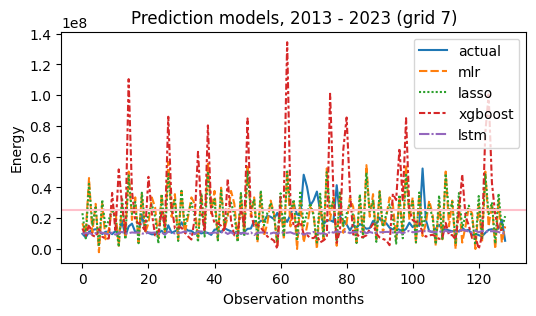

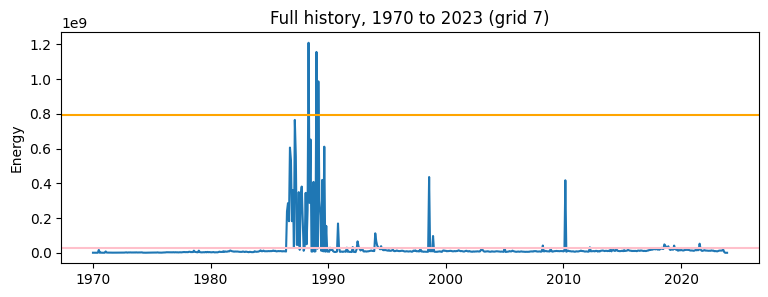

In [83]:
prediction_analyzer2(df7, transposed_df, pred_df7, 7)

Magnitude 2, actual:  8
Magnitude 2, mlr:     47
Magnitude 2, lasso:   47
Magnitude 2, xgboost: 106
Magnitude 2, lstm:    0

 Predicting future Magnitude
 1 | 2 | 3 | 4 | 5 | 6 | 7 |

mlr
20 | 19 | 0 | 0 | 0 | 0 | 0 | 
lasso
20 | 20 | 0 | 0 | 0 | 0 | 0 | 
xgboost
57 | 22 | 3 | 0 | 0 | 0 | 0 | 
lstm
60 | 0 | 0 | 0 | 0 | 0 | 0 | 

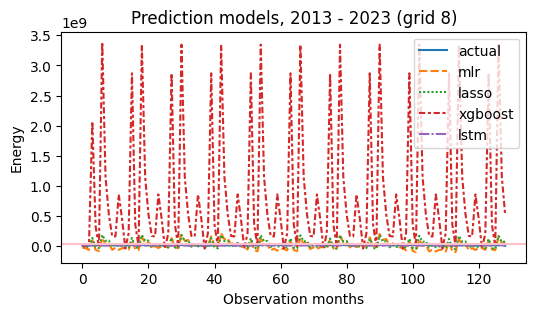

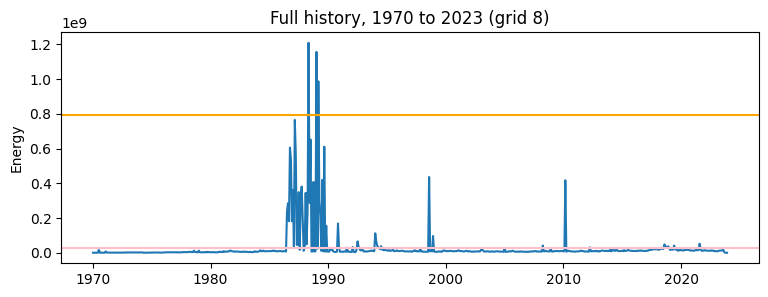

In [84]:
prediction_analyzer2(df8, transposed_df, pred_df8, 8)

Magnitude 2, actual:  7
Magnitude 2, mlr:     0
Magnitude 2, lasso:   0
Magnitude 2, xgboost: 7
Magnitude 2, lstm:    0

 Predicting future Magnitude
 1 | 2 | 3 | 4 | 5 | 6 | 7 |

mlr
60 | 0 | 0 | 0 | 0 | 0 | 0 | 
lasso
60 | 0 | 0 | 0 | 0 | 0 | 0 | 
xgboost
60 | 0 | 0 | 0 | 0 | 0 | 0 | 
lstm
60 | 0 | 0 | 0 | 0 | 0 | 0 | 

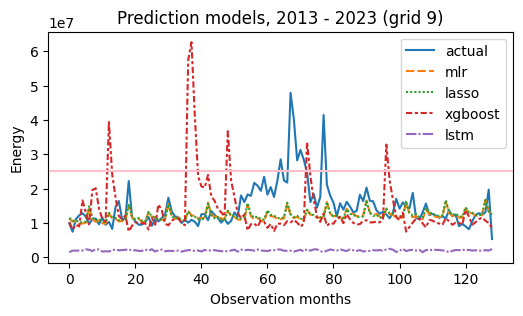

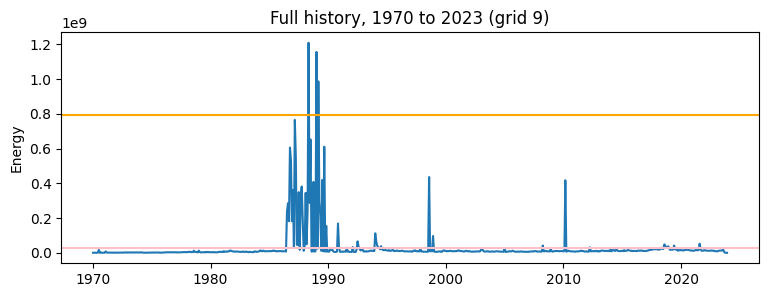

In [85]:
prediction_analyzer2(df9, transposed_df, pred_df9, 9)

### Future predictions above certain magnitude levels

In [86]:
mag1 = 10**(4.4+1.5*1)
mag2 = 10**(4.4+1.5*2)
mag3 = 10**(4.4+1.5*3)
mag4 = 10**(4.4+1.5*4)
mag5 = 10**(4.4+1.5*5)
mag6 = 10**(4.4+1.5*6)
mag7 = 10**(4.4+1.5*7)

In [87]:
def future_predictor(pred_df, k):
    print(f'Grid point {k}\n')
    print("Magnitude\n 1 | 2 | 3 | 4 | 5 | 6 | 7 |")
    for col in ['mlr','lasso','xgboost','lstm']:
        print(f"\n{col}")
        for i in range(1,8):
            mag = 10**(4.4+1.5*i)
            print(f"{len(pred_df[pred_df[col] > mag])}", end = ' | ')

In [88]:
future_predictor(pred_df0, 0)

Grid point 0

Magnitude
 1 | 2 | 3 | 4 | 5 | 6 | 7 |

mlr
60 | 0 | 0 | 0 | 0 | 0 | 0 | 
lasso
60 | 0 | 0 | 0 | 0 | 0 | 0 | 
xgboost
60 | 2 | 0 | 0 | 0 | 0 | 0 | 
lstm
60 | 0 | 0 | 0 | 0 | 0 | 0 | 